In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Activation
from keras.layers import GlobalAveragePooling1D
from keras.utils import np_utils
import tensorflow
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [2]:
%matplotlib inline
import numpy as np

from scipy.io import loadmat
import glob

### Read EEG data based on the patient ID

#### Read patient ID

In [3]:
# path to the dataset
from pathlib import Path

path = 'C:/Vandana_Jan2022/PhD/Fall 2022/NeuralNetworks/Project/MAT_raw_50Hz'

In [4]:
# Read patient id into dataframe
label_df = pd.read_excel(path+'/Labels.xlsx')
label_df.head()

,EEG_ID,OUTCOME,SURVIVAL,NOValid,DIAGNOSTIC
0,VD_014,0,0,3,2
1,VD_018,0,0,4,3
2,VD_020,1,1,3,2
3,VD_034,1,1,4,3
4,VD_037,1,0,1,0


In [5]:
# convert the datatype of column EEG_ID and make a list of all ID's
id = label_df['EEG_ID'].astype(str).values.tolist()
#id

#### Read the EEG data from the matlab (.mat) files using patient id's

In [6]:
matfiles = []

# Read all files corresponding to the patient id and having "_1_50hz" in their name
for i in id:
    for fname in Path(path).glob(f"{i}_1_50hz.mat"):
        matfiles.append(loadmat(fname, struct_as_record=True))



In [7]:
'''Check for the data --- Each recording corresponds to one patient, the data is in the form of a dictionary whose key 
is the channel name and value is the recording. The recording has 20 - 26 channels'''
matfiles[0]

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Nov 26 21:53:23 2019',
 '__version__': '1.0',
 '__globals__': [],
 'C3': array([[1.01938603],
        [2.51217465],
        [3.18769224],
        ...,
        [0.88968085],
        [0.47086718],
        [2.13244906]]),
 'C4': array([[ 1.62557648],
        [ 1.65620763],
        [ 2.13538223],
        ...,
        [-6.90832766],
        [-6.16790076],
        [-3.62713795]]),
 'Cz': array([[ 1.32473616],
        [ 1.0236021 ],
        [ 0.70656506],
        ...,
        [ 1.56659562],
        [ 5.2790914 ],
        [-1.47105923]]),
 'F3': array([[0.97618138],
        [0.73074208],
        [1.7075367 ],
        ...,
        [2.42510091],
        [5.6726594 ],
        [0.09881606]]),
 'F4': array([[ 0.29753638],
        [ 0.22719103],
        [ 0.3659132 ],
        ...,
        [-3.02775159],
        [-2.58493606],
        [-1.71874386]]),
 'F7': array([[  0.96180702],
        [ -1.15041677],
        [ -0.86724479],
 

#### PIck recordings for channels of interest, and remove headers from the dictionary

In [8]:
# header keys for removal from data dictionary
rem_list = ['__header__', '__version__', '__globals__']
 
# Remove multiple keys from dictionary
for i in range(len(matfiles)):
    for key in rem_list:
        del matfiles[i][key]

In [9]:
# data dictionary after removal of header
matfiles[0]

{'C3': array([[1.01938603],
        [2.51217465],
        [3.18769224],
        ...,
        [0.88968085],
        [0.47086718],
        [2.13244906]]),
 'C4': array([[ 1.62557648],
        [ 1.65620763],
        [ 2.13538223],
        ...,
        [-6.90832766],
        [-6.16790076],
        [-3.62713795]]),
 'Cz': array([[ 1.32473616],
        [ 1.0236021 ],
        [ 0.70656506],
        ...,
        [ 1.56659562],
        [ 5.2790914 ],
        [-1.47105923]]),
 'F3': array([[0.97618138],
        [0.73074208],
        [1.7075367 ],
        ...,
        [2.42510091],
        [5.6726594 ],
        [0.09881606]]),
 'F4': array([[ 0.29753638],
        [ 0.22719103],
        [ 0.3659132 ],
        ...,
        [-3.02775159],
        [-2.58493606],
        [-1.71874386]]),
 'F7': array([[  0.96180702],
        [ -1.15041677],
        [ -0.86724479],
        ...,
        [-11.29350574],
        [ -8.2860598 ],
        [ -4.69344218]]),
 'F8': array([[10.33193779],
        [16.92868944],


In [10]:
# Capture first 2000 data points (40 seconds, sampling frequency= 50hz) for the 10 channels of interest
data = []

# Channels of interest - 7 
Ch = ['C3', 'C4','Fp1', 'Fp2', 'T7', 'T8', 'O1', 'O2','Cz', 'Fpz']

for i in matfiles:
    # print (i) 
    # Collect values for a given dict.
    vals = []
    for a_channel in Ch:
        value = i.get(a_channel)
        if value is not None:
            vals.append(value[:2000])
    # Now add to the results list
    data.append(vals)

In [11]:
len(data[0][0])

2000

In [12]:
dataX = np.array(data, dtype=object)
dataX = np.squeeze(dataX)
dataX.shape

(274, 7, 2000)

In [13]:
dataX.resize(274, 2000, 7)
dataX.shape

(274, 2000, 7)

In [14]:
dataY = np.array(label_df['OUTCOME'][:274].values.tolist())

In [15]:
print(dataY.shape)
#print(testY.shape)

(274,)


In [16]:
dataX = np.asarray(dataX).astype(np.float32)


In [17]:
dataY = np.asarray(dataY).astype(np.float32)

## Outcome classification function

In [18]:
learningrate = 0.0001
model = Sequential()

# Block 1
model.add(Conv1D(16, kernel_size=3,strides=1,
                 name="firstCV",use_bias=False,
                 kernel_initializer="glorot_uniform", input_shape= (2000,7)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(16, kernel_size=3,strides=1, use_bias=False, kernel_initializer="glorot_uniform"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size = 4, strides=4))

# Block 2
model.add(Conv1D(32, kernel_size=3,kernel_initializer="glorot_uniform",
                 strides=1, use_bias = False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(32, kernel_size=3,strides=1, use_bias = False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size = 4, strides=4))

# Block 3
model.add(Conv1D(32, kernel_size=3,kernel_initializer="glorot_uniform",strides=1, use_bias = False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(32, kernel_size=3,strides=1, use_bias=False, name="lastCV")) # the name is used as referral for GradCAM
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size = 4, strides=4))

# Global Average Pooling operation after the third block
model.add(GlobalAveragePooling1D())

# into a final single-neuron FC layer outputting the probability
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(learning_rate=learningrate)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [19]:
hist_outcome = model.fit(dataX, dataY, epochs=50)

Epoch 1/50
9/9 [==============================] - 6s 139ms/step - loss: 0.6649 - accuracy: 0.6387
Epoch 2/50
9/9 [==============================] - 1s 120ms/step - loss: 0.6511 - accuracy: 0.6496
Epoch 3/50
9/9 [==============================] - 1s 131ms/step - loss: 0.6377 - accuracy: 0.6606
Epoch 4/50
9/9 [==============================] - 1s 121ms/step - loss: 0.6328 - accuracy: 0.6569
Epoch 5/50
9/9 [==============================] - 1s 140ms/step - loss: 0.6267 - accuracy: 0.6788
Epoch 6/50
9/9 [==============================] - 1s 108ms/step - loss: 0.6198 - accuracy: 0.6715
Epoch 7/50
9/9 [==============================] - 1s 135ms/step - loss: 0.6158 - accuracy: 0.6825
Epoch 8/50
9/9 [==============================] - 1s 112ms/step - loss: 0.6131 - accuracy: 0.6752
Epoch 9/50
9/9 [==============================] - 1s 141ms/step - loss: 0.6067 - accuracy: 0.6679
Epoch 10/50
9/9 [==============================] - 1s 118ms/step - loss: 0.5996 - accuracy: 0.6934
Epoch 11/50
9/9 [==

#### Visulaize loss and accuracy for training data

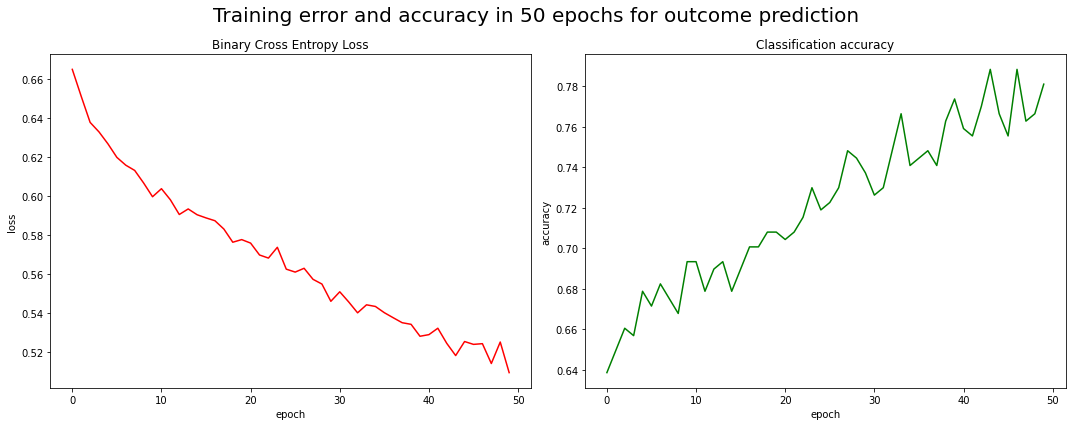

In [20]:
# plot loss
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
ax[0].plot(hist_outcome.history['loss'], color='red')
ax[0].set_title('Binary Cross Entropy Loss')
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")

 # plot accuracy
ax[1].set_title('Classification accuracy')
ax[1].plot(hist_outcome.history['accuracy'], color='green', label='train')
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
fig.suptitle("Training error and accuracy in 50 epochs for outcome prediction", fontsize = 20)
fig.tight_layout()
fig.savefig("Outcome.png")
plt.show()

## K-fold evaluation of outcome classification

In [21]:
# evaluate a model using k-fold cross-validation

def evaluate_model(dataX, dataY, n_splits=5):
    scores, histories = list(), list()
     # prepare cross validation
    skf = StratifiedKFold(n_splits, shuffle=True)
     # enumerate splits
    for train_ix, test_ix in skf.split(dataX, dataY):
     # define model
     #model = define_model()
     # select rows for train and test
         trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
     # fit model
         history = model.fit(trainX, trainY, epochs=50, verbose=0)
     # evaluate model
         _, acc = model.evaluate(testX, testY, verbose=0)
         print('> %.3f' % (acc * 100.0))
     # stores scores
         scores.append(acc)
         histories.append(history)
    return scores, histories

In [22]:
scores, histories = evaluate_model(dataX, dataY, n_splits=5)

> 78.182
> 80.000
> 87.273
> 96.364
> 98.148


In [23]:
print('Test loss:', scores) 
# print('Test accuracy:', scores[1])

Test loss: [0.7818182110786438, 0.800000011920929, 0.8727272748947144, 0.9636363387107849, 0.9814814925193787]


In [24]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
 # plot loss
     fig, ax = plt.subplots(1, 2, figsize = (15, 4))
     ax[0].plot(histories[i].history['loss'], color='blue')
     ax[0].set_title('Binary Cross Entropy Loss')
     ax[0].set_xlabel("epoch")
     ax[0].set_ylabel("loss")

     # plot accuracy
     ax[1].set_title('Classification accuracy')
     ax[1].plot(histories[i].history['accuracy'], color='orange', label='train')
     ax[1].set_xlabel("epoch")
     ax[1].set_ylabel("accuracy")
     plt.show()
    

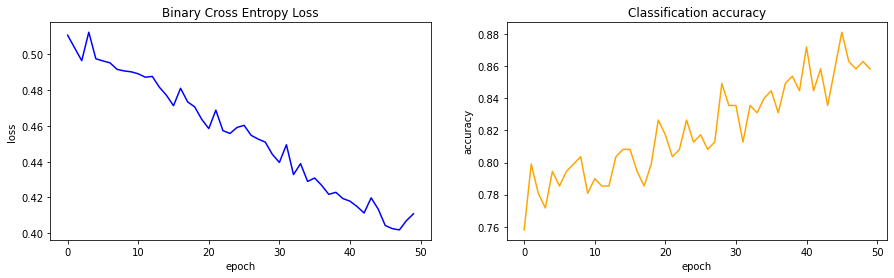

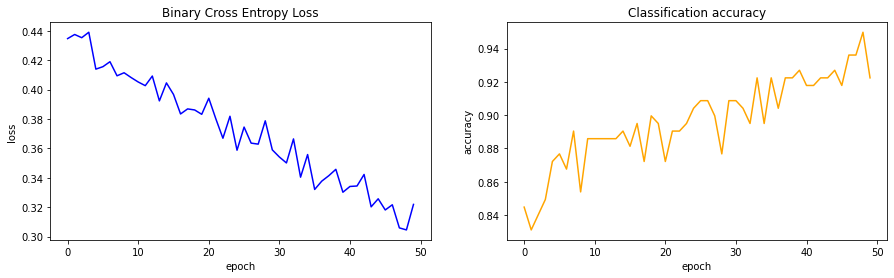

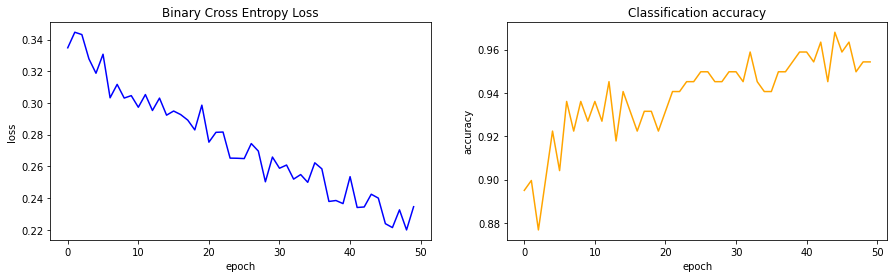

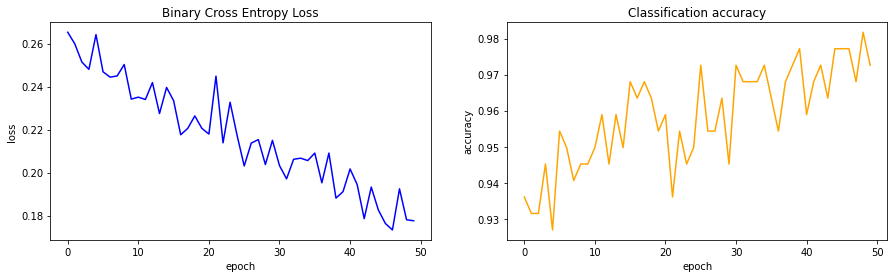

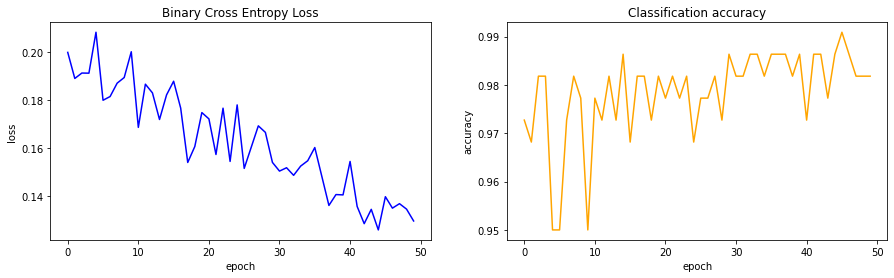

In [25]:
fig = summarize_diagnostics(histories)

# Predicting Etiology

In [26]:
#Read the diagnostic labels 
dataY_D = np.array(label_df['DIAGNOSTIC'][:274].values.tolist())

In [27]:
dataY_D

array([2, 3, 2, 3, 0, 3, 3, 3, 2, 1, 1, 1, 0, 0, 0, 3, 0, 2, 3, 0, 0, 2,
       3, 0, 0, 0, 0, 3, 3, 3, 2, 0, 3, 2, 3, 3, 1, 1, 3, 0, 0, 3, 3, 0,
       3, 3, 3, 3, 2, 0, 0, 3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 2, 3, 2, 1, 1,
       0, 1, 2, 3, 3, 3, 3, 1, 3, 3, 1, 0, 1, 3, 3, 0, 0, 3, 3, 0, 0, 3,
       3, 1, 1, 3, 3, 1, 3, 0, 0, 3, 0, 0, 3, 0, 2, 0, 0, 2, 2, 3, 0, 2,
       0, 3, 1, 1, 0, 3, 0, 1, 0, 0, 3, 3, 2, 2, 3, 3, 0, 3, 3, 1, 2, 1,
       0, 2, 2, 3, 1, 3, 0, 3, 2, 3, 0, 1, 1, 1, 1, 2, 0, 3, 3, 3, 3, 0,
       2, 0, 1, 0, 2, 2, 0, 0, 2, 2, 0, 0, 1, 1, 1, 1, 2, 3, 1, 0, 0, 1,
       1, 0, 1, 3, 3, 2, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 2, 3, 2, 0, 3, 2,
       3, 3, 3, 0, 0, 1, 3, 1, 0, 3, 3, 0, 3, 0, 3, 0, 0, 3, 1, 3, 2, 1,
       1, 3, 2, 0, 0, 3, 2, 2, 0, 3, 2, 0, 3, 3, 1, 1, 3, 3, 2, 0, 3, 3,
       1, 0, 3, 0, 0, 2, 1, 3, 0, 1, 2, 3, 3, 2, 3, 2, 3, 0, 3, 2, 0, 1,
       0, 0, 0, 0, 3, 3, 1, 2, 3, 3])

In [28]:
'''
Returns the same model architecture compiled and adjusted for the multi-class (etiology, 4 classes) setting.
'''
def compile_multi_class_TVGG_model(input_vars=(2000,7), learningrate = 0.0001, num_final_classes = 4):
    timeseries_windowsize = input_vars[0]
    num_channels = input_vars[1]
    model = Sequential()
    # Block 1
    model.add(Conv1D(16, kernel_size=3,strides=1,
                     name="firstCV",use_bias=False,
                     kernel_initializer="glorot_uniform", input_shape=(timeseries_windowsize,num_channels)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(16, kernel_size=3,strides=1, use_bias=False, kernel_initializer="glorot_uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 4, strides=4))

    # Block 2
    model.add(Conv1D(32, kernel_size=3,kernel_initializer="glorot_uniform",
                     strides=1, use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(32, kernel_size=3,strides=1, use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 4, strides=4))

    # Block 3
    model.add(Conv1D(32, kernel_size=3,kernel_initializer="glorot_uniform",strides=1, use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(32, kernel_size=3,strides=1, use_bias=False, name="lastCV")) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 4, strides=4))

    # GAP into a single output layer
    model.add(GlobalAveragePooling1D())
    # num_classes neurons activated by softmax
    model.add(Dense(num_final_classes, activation='softmax'))
    
    adam = optimizers.Adam(learning_rate=learningrate)
    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=adam,  
                metrics=['accuracy'])
    return model

In [29]:
model1 = compile_multi_class_TVGG_model(input_vars=(2000,7), learningrate = 0.0001, num_final_classes = 4)

In [30]:
# model accuracy without cross validation
hist_etiology = model1.fit(dataX, dataY_D, epochs=50)

Epoch 1/50
9/9 [==============================] - 5s 115ms/step - loss: 1.6620 - accuracy: 0.2810
Epoch 2/50
9/9 [==============================] - 1s 122ms/step - loss: 1.5816 - accuracy: 0.2847
Epoch 3/50
9/9 [==============================] - 1s 131ms/step - loss: 1.5280 - accuracy: 0.2883
Epoch 4/50
9/9 [==============================] - 1s 135ms/step - loss: 1.4756 - accuracy: 0.2883
Epoch 5/50
9/9 [==============================] - 1s 138ms/step - loss: 1.4086 - accuracy: 0.2847
Epoch 6/50
9/9 [==============================] - 1s 140ms/step - loss: 1.3855 - accuracy: 0.3066
Epoch 7/50
9/9 [==============================] - 1s 137ms/step - loss: 1.3558 - accuracy: 0.3102
Epoch 8/50
9/9 [==============================] - 1s 148ms/step - loss: 1.3452 - accuracy: 0.3540
Epoch 9/50
9/9 [==============================] - 1s 148ms/step - loss: 1.3067 - accuracy: 0.3796
Epoch 10/50
9/9 [==============================] - 1s 143ms/step - loss: 1.3112 - accuracy: 0.3942
Epoch 11/50
9/9 [==

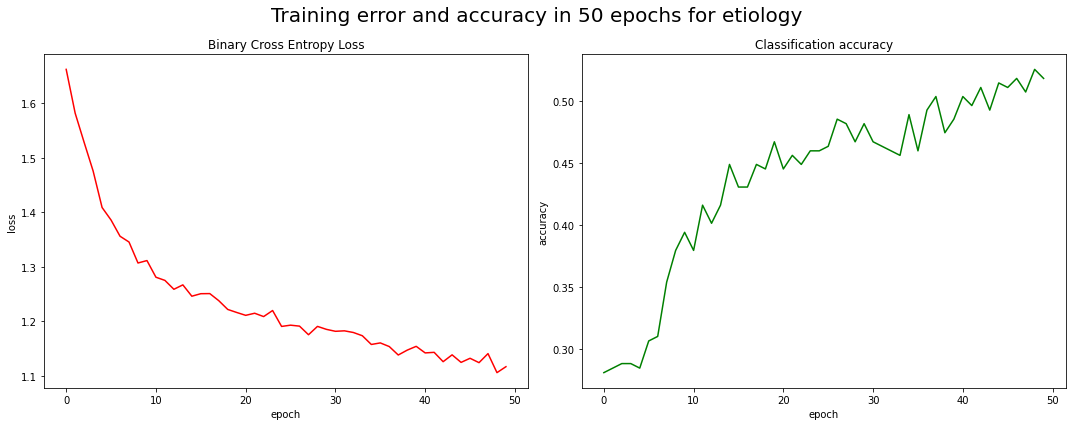

In [31]:
# plot loss
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
ax[0].plot(hist_etiology.history['loss'], color='red')
ax[0].set_title('Binary Cross Entropy Loss')
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")

 # plot accuracy
ax[1].set_title('Classification accuracy')
ax[1].plot(hist_etiology.history['accuracy'], color='green', label='train')
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
fig.suptitle("Training error and accuracy in 50 epochs for etiology", fontsize = 20)
fig.tight_layout()
fig.savefig("Etiology.png")
plt.show()

#### K-fold evaluation of etiology classification

In [32]:
# evaluate a model using k-fold cross-validation

def evaluate_model_etiology(dataX, dataY, n_splits=5):
    scores, histories1 = list(), list()
     # prepare cross validation
    skf = StratifiedKFold(n_splits, shuffle=True)
     # enumerate splits
    for train_ix, test_ix in skf.split(dataX, dataY):
     # define model
     #model = define_model()
     # select rows for train and test
         trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
     # fit model
         history = model1.fit(trainX, trainY, epochs=50, verbose=0)
     # evaluate model
         _, acc = model1.evaluate(testX, testY, verbose=0)
         print('> %.3f' % (acc * 100.0))
     # stores scores
         scores.append(acc)
         histories1.append(history)
    return scores, histories1

In [33]:
scores, histories1 = evaluate_model_etiology(dataX, dataY_D, n_splits=5)

> 49.091
> 54.545
> 67.273
> 72.727
> 85.185


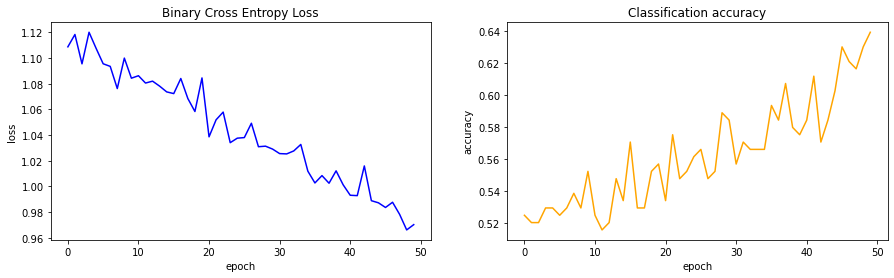

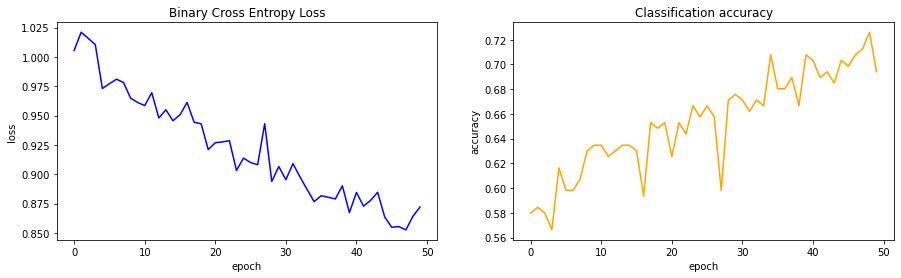

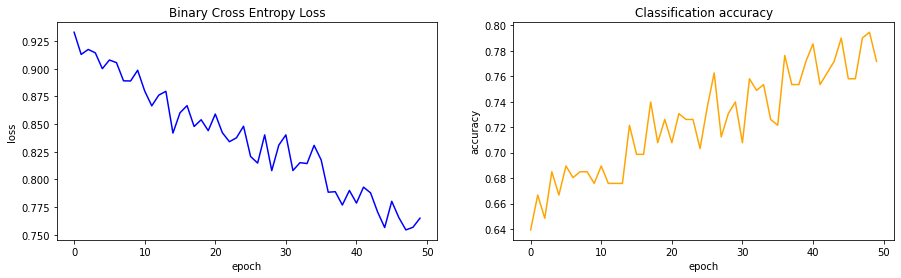

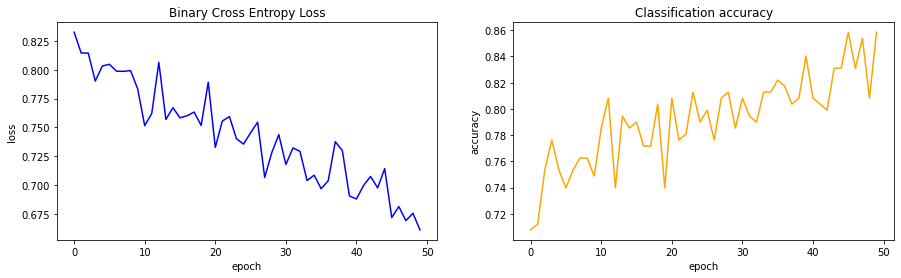

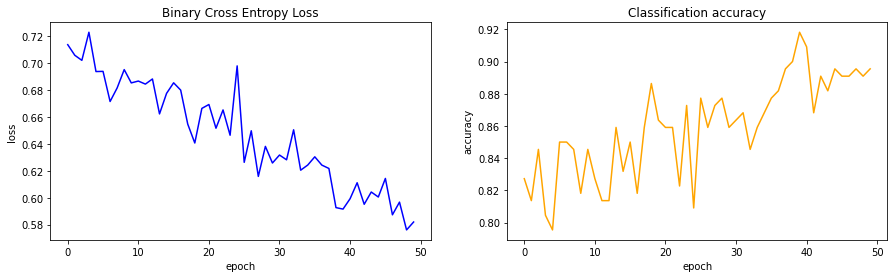

In [34]:
summarize_diagnostics(histories1)